目录：
* 实现牛顿法
* 实现线性回归中的牛顿法
* 使用数据验证线性回归中的牛顿法

# 牛顿法简介
迭代公式为
$$x_{k+1}=x_{k}-H^{-1}g_k\gamma$$
其中  
$H^{-1}$为Hessian矩阵的逆矩阵  
$g_k$为对应点的梯度


迭代结束标志为
1. 达到迭代次数
2. $||g_k||<\epsilon$


注意事项
1. 牛顿法并不能保证每次迭代时函数值都下降，即不一定收敛，解决办法：直线搜索，即搜索最优步长。具体做法是让$\gamma$取一些典型的离散值，如0.0001,0.001,0.01等，比较取哪个值时函数值下降最快，作为最优步长。
2. 牛顿法面临的问题还有Hessian矩阵可能不可导或者求解时计算量较大
3. 牛顿法找的是导数为0的点，可能找不到全局最小点
4. 对于二次函数来说，牛顿法可以一次迭代，找到导数为0的点

# 实现牛顿法
以函数
$f(x)=x_1^2+x_2^2为例$

梯度$\nabla f(x) = \begin{pmatrix}2x_1 \\2x_2\end{pmatrix}$

海森矩阵
$$H = \begin{pmatrix} 2 & 0 \\ 0 &2 \end{pmatrix}$$

迭代公式为
$x_{k+1}=x_{k} - H^{-1} \gamma\nabla f(x)$

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def dJ(x):
    return 2*x
def J(x):
    return np.sum(x**2,axis=0)

def H_inverse():
    return np.linalg.inv(np.array([[2,0],[0,2]]))

def gradient_newton(inital_x,maxiter=1e4,epsilon=1e-8):
    gamma = np.array([10**(-i) for i in range(0,5)])
    x_history = []
    x_history.append(inital_x)
    x = inital_x
    gradient = dJ(x)
    H_inv = H_inverse()
    i_iter = 0
    
    while i_iter < maxiter:
        direction = -np.tile(H_inv.dot(gradient).reshape(-1,1),(1,len(gamma)))*np.tile(gamma,(len(inital_x),1))
        x_next = x.reshape(-1,1) + direction
        x_next = x_next[:,np.argmin(J(x_next))]
        x_history.append(x_next)
        gradient = dJ(x_next)
        if np.linalg.norm(gradient) < epsilon:
            break
        i_iter +=1
        x = x_next
    return np.array(x_history)

def plot_x_history(inital_x):
    X1 = np.arange(-4,4,0.25)
    X2 = np.arange(-4,4,0.25)
    X1,X2 = np.meshgrid(X1,X2)
    Z = X1**2+X2**2
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(X1,X2,Z,alpha=0.5)
    
    res = gradient_newton(inital_x=inital_x)
    ax.scatter(res[:,0],res[:,1],res[:,0]**2+res[:,1]**2,marker='o',color='r')
    plt.show()
    

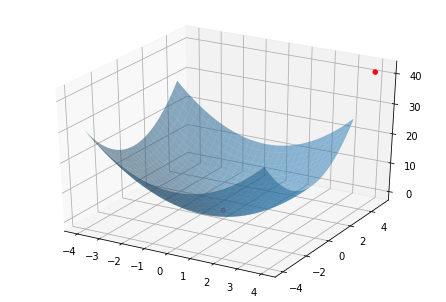

In [38]:
plot_x_history(np.array([4,5]))

# 线性回归中使用牛顿法
牛顿法的迭代公式：
$$x_{k+1}=x_{k}-H^{-1}g_k\gamma$$

线性回归的loss function：
$$\frac{1}{m}\sum\limits_{i=1}^m (\hat y-y)^2\\
= \frac{1}{m}(y-Xw)^T(y-Xw)$$

梯度为
$$\nabla_w = \frac{2}{m}(X^TXw-X^Ty)$$

Hessian矩阵为
$$\frac{2}{m}X^TX$$
其中用到公式$\nabla ^2 x^TAx = A+A^T$

经过推导可以发现，如果$\gamma$为1，则牛顿法迭代一次，即可得到线性回归的数值解

In [75]:
import numpy as np
class LinearRegression():
    def __init__(self):
        """初始化linear regression模型"""
        self.coef_ = None #w的系数
        self.interception_= None #截距
        self._theta = None

    
    def fit_newton(self,X_train,y_train,maxiter=1e4,epsilon=1e-10):
        """根据训练数据集x_train和y_train，使用牛顿法训练Linear Regression模型"""
        assert X_train.shape[0] == len(y_train), 'the size of X_train must be equal to the size of y_train'
        
        def dJ(theta,X_b,y):
            return (X_b.T).dot(X_b.dot(theta)-y)*2/len(X_b)
        
        def J(theta,X_b,y):
            try:
                return (X_b.dot(theta)-y).dot(X_b.dot(theta)-y)/len(X_b)
            except:
                return float('inf')
        
        def Hessian_inv(X_train):
            H = X_train.T.dot(X_train)*2/len(X_train)
            return np.linalg.inv(H)
        
        def newton_descent(X_b,y,inital_theta,maxiter,epsilon):
            theta = inital_theta
            i_iter = 0
            H_inv = Hessian_inv(X_b)
            gamma = np.array([10**(-i) for i in range(0,5)])
            gradient=dJ(theta,X_b,y)
            
            while i_iter < maxiter:
                temp = H_inv.dot(gradient)
                gamma,temp = np.meshgrid(gamma,temp)
                direction = -gamma*temp
                theta_next = theta.reshape(-1,1)+direction
                res = np.array([J(theta_next[:,i],X_b,y) for i in range(theta_next.shape[1])])
                theta_next = theta_next[:,np.argmin(res)]
                gradient = dJ(theta_next,X_b,y)
                theta = theta_next
                if np.linalg.norm(gradient) < epsilon:
                    break
                    
                
                i_iter += 1
                

            print("i_iter=",i_iter)
            return theta
            
            
        X_b = np.hstack([np.ones((X_train.shape[0],1)),X_train])
        inital_theta = np.zeros(X_b.shape[1])
        self._theta = newton_descent(X_b,y_train,inital_theta,maxiter,epsilon)
        self.interception_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self
        
        
    def predict(self,X_predict):
        """给待测数据集X_predict，返回表示X_predict的结果向量"""
        assert self._theta is not None,'must fit before predict'
        assert len(self._theta) == X_predict.shape[1]+1,'the feature number of X_predict must be equal to X_train'
        X_b_pre = np.hstack([np.ones((X_predict.shape[0],1)),X_predict])
        return X_b_pre.dot(self._theta)
    
    def __repr__(self):
        return "LinearReression"

## 使用自己造的虚拟数据进行验证

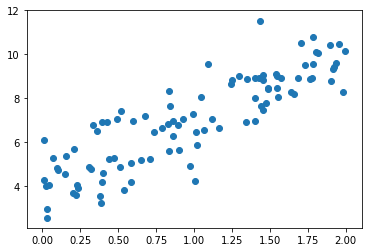

In [76]:
np.random.seed(666)
X=2 * np.random.random(size=100)
y=X*3 + 4+np.random.normal(size=100)
X = X.reshape(-1,1)
plt.scatter(X,y)

In [77]:
reg = LinearRegression()
reg.fit_newton(X,y) 

i_iter= 0


LinearReression

In [78]:
reg.coef_

array([3.00517447])

In [79]:
reg.interception_

4.023696672103892

# 使用波士顿房价预测

In [80]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
boston = load_boston()
X = boston.data
y = boston.target
X = X[ y<50 ]
y = y[ y<50 ]
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [82]:
reg = LinearRegression()
reg.fit_newton(X_train,y_train) 

i_iter= 2


LinearReression

In [83]:
reg.coef_

array([-1.29252521e-01,  5.24742121e-02, -5.83600463e-02,  6.07421517e-01,
       -1.34480129e+01,  3.00891674e+00, -9.97660506e-03, -1.33148360e+00,
        2.86720310e-01, -1.40790486e-02, -8.97099846e-01,  7.77269766e-03,
       -4.05260628e-01])

In [85]:
from sklearn.metrics import r2_score
predict = reg.predict(X_test)
r2_score(y_test,predict)

0.786034133741399

## 尝试将数据进行归一化

In [86]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

In [87]:
reg = LinearRegression()
reg.fit_newton(X_train_std,y_train) 

i_iter= 0


LinearReression

In [88]:
predict = reg.predict(X_test_std)
r2_score(y_test,predict)

0.7860341337413995

这不就是数值解嘛，哎，有什么可大惊小怪的。。。